In [166]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import flair
from flair.data import Sentence
from flair.nn import Classifier
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
from scipy.special import softmax
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [151]:
# Dataset of reddit comments with an analysis score of 1, 0, or -1
df = pd.read_csv('Reddit_Data.csv')
df['clean_comment'] = df['clean_comment'].astype(str)
df['clean_comment'] = df['clean_comment'].apply(lambda x: x.strip())
df = df[df['clean_comment'] != '']
df.reset_index(drop=True, inplace=True)

# Load the sentiment analysis model - for hugging face
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
# PT
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load the sentiment analysis model - for flair
tagger = Classifier.load('sentiment')

# Load the model for NLTK
# only download if not already downloaded
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

/Users/shasankpatel/Library/CloudStorage/OneDrive-UniversityofMaryland/SPRING24/CMSC421/cmsc421-final-project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shasankpatel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [152]:
df

,clean_comment,category
0,family mormon have never tried explain them th...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37123,jesus,0
37124,kya bhai pure saal chutiya banaya modi aur jab...,1
37125,downvote karna tha par upvote hogaya,0
37126,haha nice,1


In [153]:
# Time each model
times = []
start = time.time()

# Test flair
df_f = df.copy().head(1000)

# Convert body to Flair sentences
df_f['sentence'] = df_f['clean_comment'].apply(lambda x: Sentence(x)) # type: ignore
# Perform sentiment analysis
df_f['sentence'].apply(lambda x: tagger.predict(x))
df_f['sentiment_result'] = df_f['sentence'].apply(lambda x: x.labels[0].value)
df_f['sentiment_score'] = df_f['sentence'].apply(lambda x: x.labels[0].score)
df_f.drop(columns=['clean_comment', 'sentence'], inplace=True)
df_f['sentiment_result'].replace(['POSITIVE','NEGATIVE'], [1,-1], inplace=True)

times.append(time.time() - start)

/var/folders/bt/llk01x0n1ds62ww5wg13kz8m0000gn/T/ipykernel_10405/2756534851.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_f['sentiment_result'].replace(['POSITIVE','NEGATIVE'], [1,-1], inplace=True)
/var/folders/bt/llk01x0n1ds62ww5wg13kz8m0000gn/T/ipykernel_10405/2756534851.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('fu

In [154]:
start = time.time()
# Test hugging face
# Preprocess text ???
df_hf = df.copy().head(1000)
# tokenize
df_hf['tokens'] = df_hf['clean_comment'].apply(lambda x: tokenizer(x, padding=True, truncation=True,
                                                        max_length=512, return_tensors='pt'))
df_hf['output'] = df_hf['tokens'].apply(lambda x: model(**x))
df_hf['scores'] = df_hf['output'].apply(lambda x: softmax(x[0][0].detach().numpy()))
df_hf['ranking'] = df_hf['scores'].apply(lambda x: x.argsort()[::-1])
df_hf['sentiment_result'] = df_hf['ranking'].apply(lambda x: config.id2label[x[0]])
df_hf['first_ranking'] = df_hf['ranking'].apply(lambda x: x[0])
# only do the below if first_ranking isn't empty
if not df_hf['first_ranking'].empty:
    df_hf['sentiment_score'] = df_hf.apply(lambda x: x['scores'][x['first_ranking']], axis=1)
#df['sentiment_score'] = df.apply(lambda x: x['scores'][x['ranking'][0]], axis=1)
# Drop the intermediate columns
df_hf.drop(columns=['clean_comment', 'tokens', 'output', 'scores', 'ranking'], inplace=True)
df_hf['sentiment_result'].replace(['neutral','positive','negative'], [0,1,-1], inplace=True)

times.append(time.time() - start)

/var/folders/bt/llk01x0n1ds62ww5wg13kz8m0000gn/T/ipykernel_10405/668732342.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_hf['sentiment_result'].replace(['neutral','positive','negative'], [0,1,-1], inplace=True)
/var/folders/bt/llk01x0n1ds62ww5wg13kz8m0000gn/T/ipykernel_10405/668732342.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set

In [155]:
start = time.time()

# Test Vader
df_v = df.copy().head(1000)
df_v['sentiment_tmp'] = df_v['clean_comment'].apply(lambda x: sia.polarity_scores(x))
df_v['sentiment_score'] = df_v['sentiment_tmp'].apply(lambda x: x['compound'])
df_v['sentiment_result'] = df_v['sentiment_score'].apply(lambda x: 1 if x >= 0.05 else (-1 if x <= -0.05 else 0))
df_v.drop(columns=['sentiment_tmp', 'clean_comment'], inplace=True)

times.append(time.time() - start)

In [156]:
true_vals = pd.DataFrame(df['category'].head(1000).copy())
test_df = pd.concat([true_vals['category'],
                     df_f['sentiment_result'], 
                     df_hf['sentiment_result'], 
                     df_v['sentiment_result']], axis=1, keys=['True Labels',
                                                              'Flair', 
                                                              'Hugging Face',
                                                              'Vader'])
test_df

,True Labels,Flair,Hugging Face,Vader
0,1,1,0,1
1,1,-1,0,1
2,-1,-1,-1,1
3,0,-1,0,1
4,1,1,0,1
...,...,...,...,...
995,1,-1,0,1
996,1,1,0,1
997,0,-1,-1,-1
998,1,1,1,1


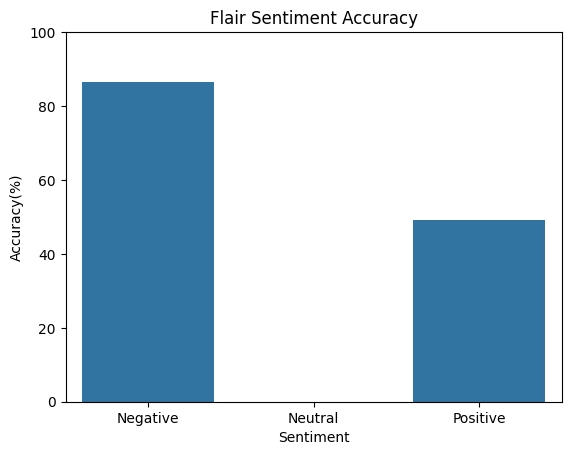

In [168]:
test_f = pd.concat([test_df['True Labels'], test_df['Flair']], axis=1)
test_f['Match'] = test_f['Flair'].eq(test_f['True Labels'])
test_fa = pd.DataFrame(test_f.groupby('True Labels').Match.mean().mul(100).round(2))
test_fa['True Labels'] = ['Negative', 'Neutral', 'Positive']
ax = sns.barplot(x=test_fa['True Labels'], y=test_fa['Match'])
ax.set(xlabel='Sentiment', ylabel='Accuracy(%)', title='Flair Sentiment Accuracy')
ax.set_ylim(0, 100)
ax
# plt.savefig('Flair Sentiment Accuracy')

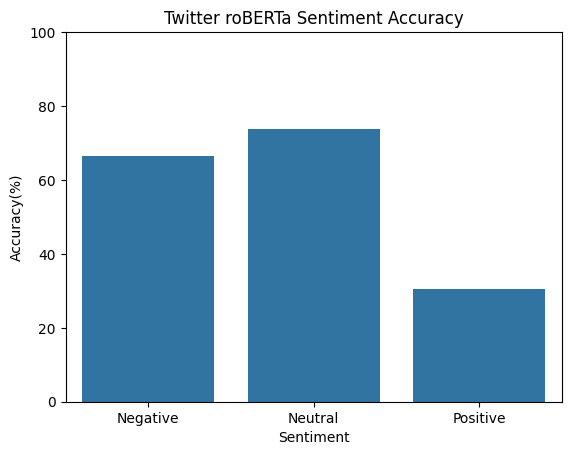

In [167]:
test_hf = pd.concat([test_df['True Labels'], test_df['Hugging Face']], axis=1)
test_hf['Match'] = test_hf['Hugging Face'].eq(test_hf['True Labels'])
test_hfa = pd.DataFrame(test_hf.groupby('True Labels').Match.mean().mul(100).round(2))
test_hfa['True Labels'] = ['Negative', 'Neutral', 'Positive']
ax = sns.barplot(x=test_hfa['True Labels'], y=test_hfa['Match'])
ax.set(xlabel='Sentiment', ylabel='Accuracy(%)', title='Twitter roBERTa Sentiment Accuracy')
ax.set_ylim(0, 100)
ax
# plt.savefig('Twitter roBERTa Sentiment Accuracy')

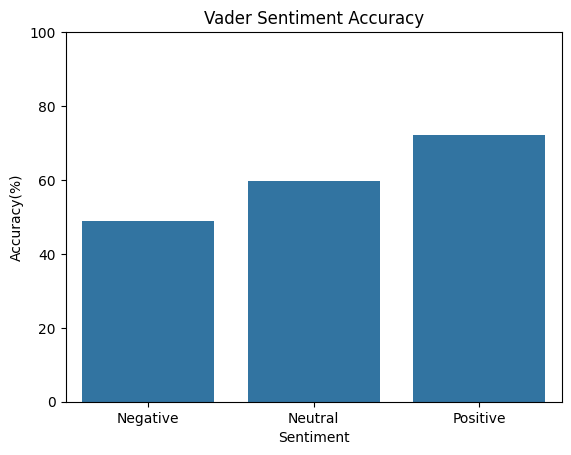

In [169]:
test_v = pd.concat([test_df['True Labels'], test_df['Vader']], axis=1)
test_v['Match'] = test_v['Vader'].eq(test_v['True Labels'])
test_va = pd.DataFrame(test_v.groupby('True Labels').Match.mean().mul(100).round(2))
test_va['True Labels'] = ['Negative', 'Neutral', 'Positive']
ax = sns.barplot(x=test_va['True Labels'], y=test_va['Match'])
ax.set(xlabel='Sentiment', ylabel='Accuracy(%)', title='Vader Sentiment Accuracy')
ax.set_ylim(0, 100)
ax
# plt.savefig('Vader Sentiment Accuracy')

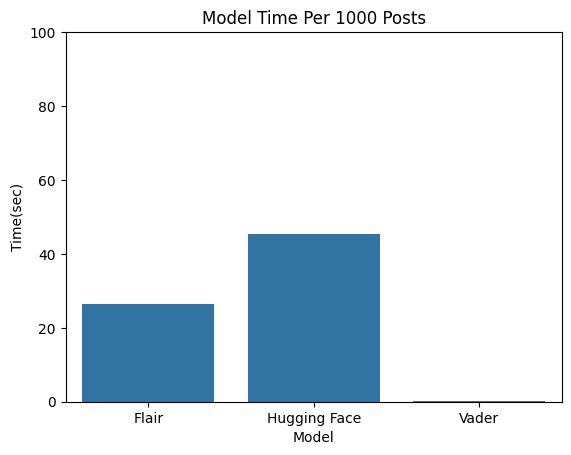

In [170]:
ax = sns.barplot(x=['Flair', 'Hugging Face', 'Vader'], y=times)
ax.set(xlabel='Model', ylabel='Time(sec)', title='Model Time Per 1000 Posts')
ax.set_ylim(0, 100)
ax
# plt.savefig('Model Time Per 1000 Posts')